_Lambda School Data Science, Unit 2_

---

👇 **Do not change the code in this cell.** If you're working in Google Colab, you can run this cell to install `category_encoders`.

In [1]:
%%capture
import sys

if 'google.colab' in sys.modules:
    # Install packages in Colab
    !pip install category_encoders

 
# Sprint Challenge: Predict Steph Curry's Shots 🏀

For your Sprint Challenge, you'll use a dataset with all Steph Curry's NBA field goal attempts from October 2009 through June 2019 (regular season and playoffs). The dataset was collected with the [nba_api](https://github.com/swar/nba_api) Python library.

You'll create a model to predict whether Curry will make a shot based on his past perfomance.

# Directions

This notebook contains 10 tasks, which cover the material we've learned in this sprint. Here's a summary:

- **Task 1:** Importing data.
- **Task 2:** Feature engineering.
- **Task 3:** Splitting data into a feature matrix and target vector.
- **Task 4:** Splitting data into training, validation, and test sets.
- **Task 5:** Establishing baseline accuracy.
- **Task 6:** Building a model with a transformer and a tree-based predictor.
- **Task 7:** Calculating training and validation accuracy.
- **Task 8 (`stretch goal`):** Tuning model hyperparameters.
- **Task 9:** Calculating precision and recall from a confusion matrix.
- **Task 10 (`stretch goal`):** Plotting a confusion matrix.

For each task you should do the following:

- Read the task instructions.
- Write your code in the cell below the task. Delete the `raise 
NotImplementedError` before your start.
- Run the testing cell below the task. If you get an error, read the error message and re-evaluate your code.

**You should limit your code to the following libraries:**

- `category_encoders`
- `numpy`
- `matplotlib`
- `pandas`
- `sklearn`



In [2]:
from category_encoders import OneHotEncoder, OrdinalEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, plot_confusion_matrix, classification_report
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import RandomizedSearchCV

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

# I. Wrangle Data

**Task 1:** Change the code below to import your dataset. Be sure to examine the columns carefully and determine if one of them should be set at the index. 

In [3]:
'''T1. Import DataFrame `df`'''

url = 'https://drive.google.com/uc?export=download&id=1fL7KPyxgGYfQDsuJoBWHIWwCAf-HTFpX'
local_path = '/Users/keila/Documents/Lambda/Units_Git/DS-Unit-2-Kaggle-Challenge/data/curry.csv'

# Function to read csv
def wrangle(path):
    df = pd.read_csv(path, parse_dates = ['game_date'], index_col = 'game_date')
    
    # drop constant
    df.drop(columns = 'player_name', inplace = True)
    
    return df

df = wrangle(url)
df.head()

,game_id,game_event_id,period,minutes_remaining,seconds_remaining,action_type,shot_type,shot_zone_basic,shot_zone_area,shot_zone_range,shot_distance,loc_x,loc_y,shot_made_flag,htm,vtm,season_type,scoremargin_before_shot
game_date,,,,,,,,,,,,,,,,,,
2009-10-28,20900015,4,1,11,25,Jump Shot,3PT Field Goal,Above the Break 3,Right Side Center(RC),24+ ft.,26,99,249,0,GSW,HOU,Regular Season,2.0
2009-10-28,20900015,17,1,9,31,Step Back Jump shot,2PT Field Goal,Mid-Range,Left Side Center(LC),16-24 ft.,18,-122,145,1,GSW,HOU,Regular Season,0.0
2009-10-28,20900015,53,1,6,2,Jump Shot,2PT Field Goal,In The Paint (Non-RA),Center(C),8-16 ft.,14,-60,129,0,GSW,HOU,Regular Season,-4.0
2009-10-28,20900015,141,2,9,49,Jump Shot,2PT Field Goal,Mid-Range,Left Side(L),16-24 ft.,19,-172,82,0,GSW,HOU,Regular Season,-4.0
2009-10-28,20900015,249,2,2,19,Jump Shot,2PT Field Goal,Mid-Range,Left Side Center(LC),16-24 ft.,16,-68,148,0,GSW,HOU,Regular Season,0.0


In [4]:
type(df.index)

pandas.core.indexes.datetimes.DatetimeIndex

**Task 1 Testing**

In [5]:
'''T1 Testing'''

assert isinstance(df, pd.DataFrame), 'Have you created a DataFrame named `df`?'
assert len(df) == 13958, 'Is `df` the correct length?'


**Task 2a:** Engineer at least 1 new feature. You can use something from the list below or your own idea.

- **Homecourt Advantage**: Is the home team (`htm`) the Golden State Warriors (`GSW`) ?
- **Opponent**: Who is the other team playing the Golden State Warriors?
- **Seconds remaining in the period**: Combine minutes remaining with seconds remaining, to get the total number of seconds remaining in the period.
- **Seconds remaining in the game**: Combine period, and seconds remaining in the period, to get the total number of seconds remaining in the game. A basketball game has 4 periods, each 12 minutes long.
- **Made previous shot**: Was Steph Curry's previous shot successful?

**Task 2b (`stretch goal — optional`):** Create a total of 3 new features, using your own ideas or the list above. Make sure you're not just duplicating features that are already in the feature matrix.

In [6]:
"""T2. Create new feature"""

# create feature of homecourt advantage
df['homecourt_advantage'] = (df['htm'] == 'GSW').astype(int)

# create feature of seconds remaining in period
df['seconds_left_period'] = (df['minutes_remaining']*60) + df['seconds_remaining']

# creature feature of seconds remaining in game, which will require a feature of periods left
df['periods_left'] = 4 - df['period']

df['seconds_left_game'] = df['seconds_left_period'] + (df['periods_left']*(12*60))

# dropping column of periods left bc this data is kind of already present in period
df.drop(columns = 'periods_left', inplace = True)

**Task 2 Test**

In [7]:
'''T2 Testing'''

assert df.shape[1] >= 20, '`df` does not appear to have new features.'


# II. Split Data

**Task 3:** Divide the DataFrame `df` into the feature matrix `X` and the target vector `y`. Your target is `'shot_made_flag'`.

In [8]:
'''T3. Create `X` and `y`.'''
# Split data into feature matrix and target vector
target = 'shot_made_flag'
y = df[target]
X = df.drop(columns = target)

**Task 3 Test**

In [9]:
'''T3 Tests'''

assert y.shape == (13958,), '`y` either has the wrong number of rows, or is two-dimentional.'
assert len(X) == 13958, '`X` has the wrong number of rows.'
assert X.shape[1] > 1, '`X` has the wrong number of columns'
assert 'shot_made_flag' not in X.columns, 'Target is still part of feature matrix.' 

**Task 4:** Divide your dataset into training, validation, and test sets. 

- Your training set (`X_train`, `y_train`) should contain games from the 2009-10 season through the end of the 2016-17 season.
- Your validation set (`X_val`, `y_val`) should contain games from the 2017-18 season.
- Your test set (`X_test`, `y_test`) should contain games from the 2018-2019 season.
- **Tip:** The NBA season begins in October and ends in June.

In [10]:
'''T4. Create training and val'''
# Split X and y into training, validation, and test sets

# train set will be from oldest dates up until end of 2016-2017 season, which ends in June
train_cutoff = '2017-07-01'
train_mask = X.index < train_cutoff

# validation and test set have their cutoff as summer of 2018
val_test_cutoff = '2018-07-01'

# validation set will be 2017-2018 season, meaning Oct 2017 - June 2018
val_mask = (X.index >= train_cutoff) & (X.index < val_test_cutoff)

# test set will be 2018-2019 season, so we just cutoff at July 2018
test_mask = X.index > val_test_cutoff

# Apply train mask to X and y
X_train, y_train = X.loc[train_mask], y.loc[train_mask]

# Apply val mask to X and y
X_val, y_val = X.loc[val_mask], y.loc[val_mask]

# Apply test mask to X and y
X_test, y_test = X.loc[test_mask], y.loc[test_mask]

**Test 4**

In [11]:
'''T4 Tests'''
assert len(X_train) == len(y_train) == 11081
assert len(X_val) == len(y_val) == 1168
assert len(X_test) == len(y_test) == 1709


# III. Establish Baseline

**Task 5:** Establish the baseline accuracy score for this classification problem using your training set. Save the score to the variable `baseline_acc`.

In [12]:
'''T5. Calculate baseline accuracy `baseline_acc`.'''

# YOUR CODE HERE
baseline_acc = y_train.value_counts(normalize = True).max()
print('Baseline Accuracy:', baseline_acc)

Baseline Accuracy: 0.5272087356736757


**Task 5 Testing**

In [13]:
'''T5 Testing'''

assert isinstance(baseline_acc, float)
assert 0.0 <= baseline_acc <= 1.0


# IV. Build Model

**Task 6:** Build a model that includes (1) a transformer for categorical features and (2) a tree-based predictor. You should combine these two components (and any other pieces you think are necessary) in a pipeline named `model`. Be sure to fit your model to your training data.

In [14]:
'''T6. Build a pipeline `model` with encoder and tree-based predictor.'''

# YOUR CODE HERE
model = make_pipeline(OrdinalEncoder(cols = ['shot_zone_basic', 'shot_zone_area', 
                                             'shot_zone_range', 'action_type', 'vtm', 'htm']),
                      OneHotEncoder(cols =['shot_type','season_type'], 
                                    use_cat_names= True), 
                      RandomForestClassifier(n_jobs = -1,
                                             n_estimators = 125,
                                             max_samples = 0.3,
                                             max_depth = 15,
                                             random_state = 42))

model.fit(X_train, y_train);

/Users/keila/Documents/Lambda/Units_Git/DS-Unit-2-Kaggle-Challenge/unit2kagenv/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


**Task 6 Testing**

In [16]:
'''T6 Testing'''

from sklearn.pipeline import Pipeline
assert isinstance(model, Pipeline), '`model` should be type `Pipeline`.'

# Does `model` Pipeline have multiple components?
assert len(model.named_steps.keys()) > 1, '`model` should have more than one component.'

# Has `model` been trained?
assert hasattr(model, 'classes_'), 'Have you trained `model`?'


# V. Check Metrics

**Task 7:** Check the training and validation accuracy of your model, and assign the scores to `train_acc` and `val_acc` respectively.

In [17]:
'''T7. Calculate train and test accuracy.'''

# Get training accuracy
train_acc = model.score(X_train, y_train)

# Get validation accuracy
val_acc = model.score(X_val, y_val)

print('Training Accuracy Score:', train_acc)
print('Validation Accuracy Score:', val_acc)

Training Accuracy Score: 0.822218211352766
Validation Accuracy Score: 0.6181506849315068


**Task 7 Test**

In [18]:
'''T7 Testing'''

# Is `training_acc` a float between 0.0 and 1.0?
assert isinstance(train_acc, float)
assert 0.0 <= train_acc <= 1.0

# Is `validation_acc` a float between 0.0 and 1.0?
assert isinstance(val_acc, float)
assert 0.0 <= val_acc <= 1.0


# VI. Tune Model

**Task 8 (`stretch goal — optional`):** Using your training and validation sets as a guide, tune the hyperparameters of your model to see if you can improve its accuracy. You can perform your tuning "by hand" or using [`RandomizedSearchCV`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html).

- Important hyperparameters for all tree-based models: `max_depth`.
- Important hyperparameters for random forest models: `n_estimators`, `max_samples`. 
- Important hyperparametes for gradient boosting tree models: `n_estimators`, `learning_rate`.
- **TIP:** If you use `RandomizedSearchCV`, set `n_iter` to `3`. Any larger and the auto-grader will stop working.
- **TIP:** Since you already created a validation set above, there is no need to do k-fold cross-validation here. Set `cv` to `None`.

Once you're satisfied with your model's performance on the validation set (if you can get above `0.6`, you're doing good), calculate its accuracy with your test set. Assign the result to `test_acc`.

In [19]:
'''T8. Tune model.'''

# YOUR CODE HERE

# Set up estimator
estimator = make_pipeline(OrdinalEncoder(cols = ['shot_zone_basic', 'shot_zone_area', 
                                             'shot_zone_range', 'action_type', 'vtm', 'htm']),
                      OneHotEncoder(cols =['shot_type','season_type'], 
                                    use_cat_names= True), 
                      RandomForestClassifier(n_jobs = -1,
                                             random_state = 42))

# Choose hyperparameter I want to tune
params = {'randomforestclassifier__n_estimators': range(2, 250, 25)}


# Run RandomizedSearchCV
rs_model = RandomizedSearchCV(estimator,
                              param_distributions = params,
                              n_iter = 3,
                              cv = None,
                              n_jobs = -1,
                              verbose = 1)

# Fit RandomizedSearchCV to training data
rs_model.fit(X_train, y_train);

Fitting 5 folds for each of 3 candidates, totalling 15 fits


/Users/keila/Documents/Lambda/Units_Git/DS-Unit-2-Kaggle-Challenge/unit2kagenv/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


In [20]:
print(rs_model.best_score_)
print(rs_model.best_params_)

# After tuning by hand, found 125 to be better

0.6352305128242706
{'randomforestclassifier__n_estimators': 127}


In [21]:
# Set up estimator, including latest tuned hyperparameter
estimator2 = make_pipeline(OrdinalEncoder(cols = ['shot_zone_basic', 'shot_zone_area', 
                                             'shot_zone_range', 'action_type', 'vtm', 'htm']),
                           OneHotEncoder(cols =['shot_type','season_type'], 
                                    use_cat_names= True), 
                           RandomForestClassifier(n_jobs = -1,
                                                 n_estimators = 125,
                                                 random_state = 42))

# Choose hyperparameter I want to tune
params2 = {'randomforestclassifier__max_samples': np.arange(0.1, 1.0, 0.2)}


# Run RandomizedSearchCV
rs2_model = RandomizedSearchCV(estimator2,
                              param_distributions = params2,
                              n_iter = 3,
                              cv = None,
                              n_jobs = -1,
                              verbose = 1)

# Fit RandomizedSearchCV to training data
rs2_model.fit(X_train, y_train);

Fitting 5 folds for each of 3 candidates, totalling 15 fits


/Users/keila/Documents/Lambda/Units_Git/DS-Unit-2-Kaggle-Challenge/unit2kagenv/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


In [22]:
print(rs2_model.best_score_)
print(rs2_model.best_params_)

0.6383894797177699
{'randomforestclassifier__max_samples': 0.30000000000000004}


In [23]:
# Set up estimator, including latest tuned hyperparameter
estimator3 = make_pipeline(OrdinalEncoder(cols = ['shot_zone_basic', 'shot_zone_area', 
                                             'shot_zone_range', 'action_type', 'vtm', 'htm']),
                           OneHotEncoder(cols =['shot_type','season_type'], 
                                    use_cat_names= True), 
                           RandomForestClassifier(n_jobs = -1,
                                                 n_estimators = 227,
                                                 max_samples = 0.1,
                                                 random_state = 42))

# Choose hyperparameter I want to tune
params3 = {'randomforestclassifier__max_depth': range(2, 32, 2)}


# Run RandomizedSearchCV
rs3_model = RandomizedSearchCV(estimator3,
                              param_distributions = params3,
                              n_iter = 3,
                              cv = None,
                              n_jobs = -1,
                              verbose = 1)

# Fit RandomizedSearchCV to training data
rs3_model.fit(X_train, y_train);

Fitting 5 folds for each of 3 candidates, totalling 15 fits


/Users/keila/Documents/Lambda/Units_Git/DS-Unit-2-Kaggle-Challenge/unit2kagenv/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


In [24]:
print(rs3_model.best_score_)
print(rs3_model.best_params_)

# After tuning by hand, found 15 is better 

0.6533693529975949
{'randomforestclassifier__max_depth': 16}


In [25]:
test_acc = model.score(X_test, y_test)
print('Testing Accuracy Score:', test_acc)

Testing Accuracy Score: 0.6459918080748976


**Task 8 Testing**

In [26]:
'''T8 Testing'''
assert isinstance(test_acc, float)
assert 0.0 <= test_acc <= 1.0

# VII. Communication

**Task 9:** Below is a confusion matrix for the model that your instructor made for this challenge (based on the **test data**). Calculate the precision and recall of this model, naming them `instructor_precision` and `instructor_recall`, respectively.

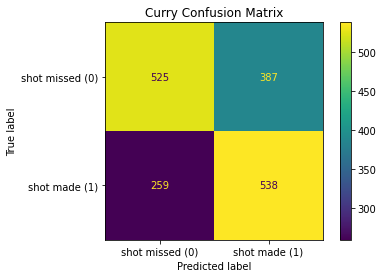

In [27]:
'''T9. Calculate precision and recall'''
# YOUR CODE HERE
instructor_precision = 538 / (538+387)
instructor_recall = 538 / (259+538)
print('Instuctor model precision', instructor_precision)
print('Instuctor model recall', instructor_recall)

Instuctor model precision 0.5816216216216217
Instuctor model recall 0.6750313676286073


**Task 9 Testing**

In [28]:
'''T9 Testing'''
assert isinstance(instructor_precision, float)
assert isinstance(instructor_recall, float)
assert 0 <= instructor_precision <= 1
assert 0 <= instructor_recall <= 1

**Task 10 (`stretch goal — optional`):** Plot confusion matrix for your model using your **test data**. Does your model have higher recall or higher precision? How does your model's metrics compare to the metrics you calculated above?

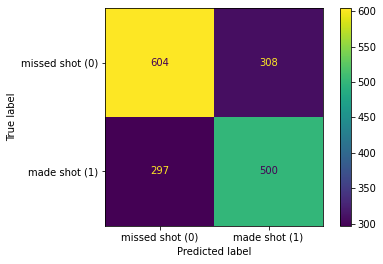

In [29]:
'''T10. Plot ROC curve.'''
# YOUR CODE HERE
plot_confusion_matrix(
    model,
    X_test, 
    y_test,
    values_format='.0f',
    display_labels=['missed shot (0)', 'made shot (1)']
);

In [32]:
my_precision = 500/(308+500)
my_recall = 500 / (297+500)
my_accuracy = (500+604) /(500+604+308+297)
print('My model precision:', my_precision)
print('My model recall:', my_recall)
print('My model accuracy:', my_accuracy)

My model precision: 0.6188118811881188
My model recall: 0.6273525721455459
My model accuracy: 0.6459918080748976


My precision is slightly higher, while my recall is slightly lower than instructor's.

According to the confusion matrix, my precision is lower for the test data than when I found the accuracy score of the test data.